# Objectives {.unnumbered}

By the end of this lab, you will:
1. Load and analyze the **Lightcast dataset** in **Spark DataFrame**.
2. Create **five easy and three medium-complexity visualizations** using **Plotly**.
3. Explore **salary distributions, employment trends, and job postings**.
4. Analyze **skills in relation to NAICS/SOC/ONET codes and salaries**.
5. Customize **colors, fonts, and styles** in all visualizations (**default themes result in a 2.5-point deduction**).
6. Follow **best practices for reporting on data communication**.

# Step 1: Load the Dataset {.unnumbered}


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "vscode"
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, to_date, split, explode, when, lit
from pyspark.sql.window import Window
import pyspark.sql.functions as F


# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("lightcast_job_postings.csv")

# Show Schema and Sample Data
df.printSchema()
df.show(5)


root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

# Salary Distribution by Employment Type
- Identify salary trends across different employment types.
- **Filter the dataset**
  - Remove records where **salary is missing or zero**.
- **Aggregate Data**
  - Group by **employment type** and compute salary distribution.
- **Visualize results**
  - Create a **box plot** where:
    - **X-axis** = `EMPLOYMENT_TYPE_NAME`
    - **Y-axis** = `SALARY_FROM`
  - Customize **colors, fonts, and styles** to avoid a **2.5-point deduction**.
- **Explanation:** Write two sentences about what the graph reveals.



In [2]:
# Your Code for 1st question here
df_filtered = df.filter((col("SALARY_FROM").isNotNull()) & (col("SALARY_FROM") > 0))

fig = px.box(
    df_filtered, 
    x='EMPLOYMENT_TYPE_NAME', 
    y='SALARY_FROM',
    title='Salary Distribution Across Employment Types',
    labels={
        'EMPLOYMENT_TYPE_NAME': 'Employment Type', 
        'SALARY_FROM': 'Salary (From)'
    },
    color='EMPLOYMENT_TYPE_NAME',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    template='plotly_white'
)

fig.update_layout(
    font=dict(family="Arial, sans-serif", size=12),
    title_font_size=16,
    title_x=0.5,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    showlegend=False,
    xaxis_tickangle=-45
)

fig.update_xaxes(
    title_standoff=25
)

fig.update_yaxes(
    title_standoff=25,
    tickformat='$,.0f' 
)

pio.write_html(fig, file='salary_distribution_boxplot.html')
fig.show()
# summary_stats = df_filtered.groupby('EMPLOYMENT_TYPE_NAME')['SALARY_FROM'].agg(['mean', 'median', 'min', 'max']).round(2)
# print(summary_stats)

Based on the salary distribution boxplot, full-time positions (with ≥32 hours) show the highest median salary and the widest salary range, indicating more variability and potentially higher earning potential compared to part-time employment types. The graph also reveals significant outliers in each employment category, particularly in full-time positions, where several high-salary data points extend well above $400,000, suggesting exceptional compensation opportunities for some full-time roles.

# Salary Distribution by Industry
- Compare salary variations across industries.
- **Filter the dataset**
  - Keep records where **salary is greater than zero**.
- **Aggregate Data**
  - Group by **NAICS industry codes**.
- **Visualize results**
  - Create a **box plot** where:
    - **X-axis** = `NAICS2_NAME`
    - **Y-axis** = `SALARY_FROM`
  - Customize colors, fonts, and styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [3]:
# Your code for 2nd question here
fig = px.box(
    df_filtered, 
    x='NAICS2_NAME', 
    y='SALARY_FROM',
    title='Salary Distribution Across Industries',
    labels={
        'NAICS2_NAME': 'Industry', 
        'SALARY_FROM': 'Salary (From)'
    },
    color='NAICS2_NAME',
    color_discrete_sequence=px.colors.qualitative.Set3,
    template='plotly_white'
)

fig.update_layout(
    font=dict(family="Arial, sans-serif", size=12),
    title_font_size=16,
    title_x=0.5,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    showlegend=False,
    xaxis_tickangle=-45,
    height=600
)

fig.update_xaxes(
    title_standoff=25
)

fig.update_yaxes(
    title_standoff=25,
    tickformat='$,.0f'
)

pio.write_html(fig, file='salary_by_industry_boxplot.html')
fig.show()

The box plot reveals substantial salary variations across different industries, with sectors like Professional, Scientific, and Technical Services, Information, and Finance and Insurance showing higher median salaries and more extensive salary ranges compared to industries like Arts, Entertainment, and Recreation or Agriculture, Forestry, Fishing, and Hunting. Additionally, the visualization highlights significant salary outliers in multiple industries, particularly in Professional Services and Information, where some individual salaries extend well beyond $600,000, indicating exceptional compensation opportunities in those sectors.

# Job Posting Trends Over Time
- Analyze how job postings fluctuate over time.
- **Aggregate Data**
  - Count job postings per **posted date (`POSTED`)**.
- **Visualize results**
  - Create a **line chart** where:
    - **X-axis** = `POSTED`
    - **Y-axis** = `Number of Job Postings`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

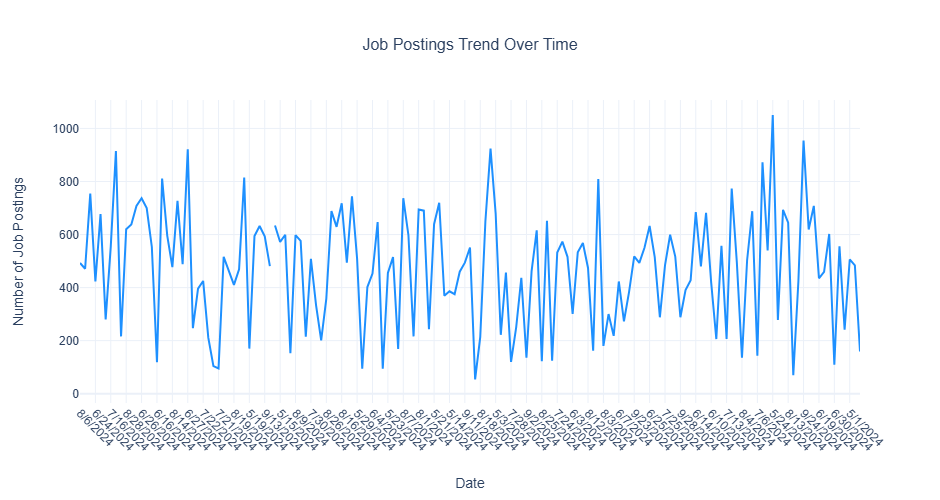

In [4]:
df_agg = df.groupBy('POSTED').agg(count('*').alias('Number of Postings'))

job_postings_trend = df_agg.toPandas()

fig = px.line(
    job_postings_trend, 
    x='POSTED', 
    y='Number of Postings',
    title='Job Postings Trend Over Time',
    labels={'POSTED': 'Date', 'Number of Postings': 'Number of Job Postings'},
    color_discrete_sequence=['#1E90FF'],
    template='plotly_white'
)

fig.update_layout(
    font=dict(family="Arial, sans-serif", size=12),
    title_font_size=16,
    title_x=0.5,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=500
)

fig.update_xaxes(
    title_standoff=25,
    tickangle=45
)

fig.update_yaxes(
    title_standoff=25
)

pio.write_html(fig, file='job_postings_trend.html')
fig.show()

The line chart demonstrates significant day-to-day volatility in job postings, with daily volumes ranging from around 200 to nearly 1,000 job listings and showing a cyclical pattern that suggests potential weekly or bi-weekly fluctuations in hiring activity. Despite the considerable variations, there's no immediately apparent long-term upward or downward trend, indicating a relatively stable job market during the observed time period with regular short-term oscillations in posting volumes.

# Top 10 Job Titles by Count
- Identify the most frequently posted job titles.
- **Aggregate Data**
  - Count the occurrences of each **job title (`TITLE_NAME`)**.
  - Select the **top 10 most frequent titles**.
- **Visualize results**
  - Create a **bar chart** where:
    - **X-axis** = `TITLE_NAME`
    - **Y-axis** = `Job Count`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

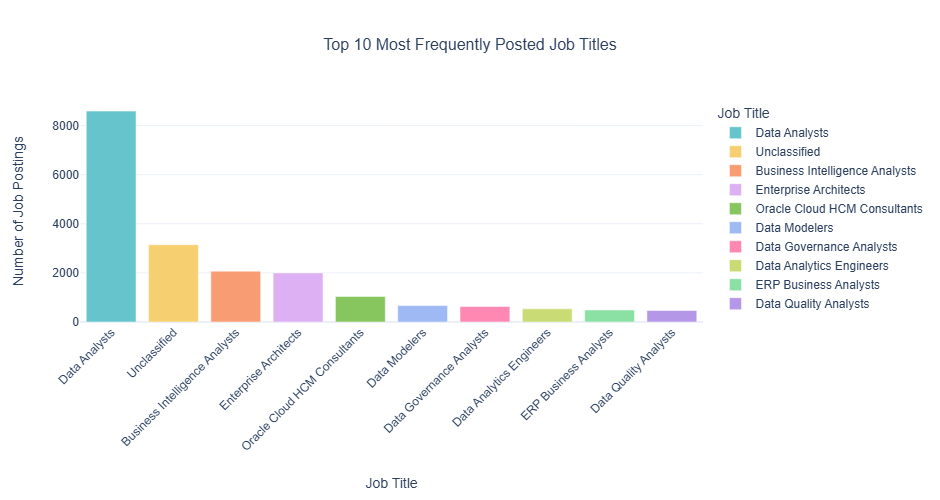

In [5]:
# Your code for 4th question here
# Top Job Titles
top_job_titles = df.groupBy("TITLE_NAME") \
    .agg(count("*").alias("Number of Postings")) \
    .orderBy(col("Number of Postings").desc()) \
    .limit(10) \
    .select(col("TITLE_NAME").alias("Job Title"), col("Number of Postings"))

fig = px.bar(
    top_job_titles, 
    x='Job Title', 
    y='Number of Postings',
    title='Top 10 Most Frequently Posted Job Titles',
    labels={
        'Job Title': 'Job Title', 
        'Number of Postings': 'Number of Job Postings'
    },
    color='Job Title',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    template='plotly_white'
)

fig.update_layout(
    font=dict(family="Arial, sans-serif", size=12),
    title_font_size=16,
    title_x=0.5,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=500,
    xaxis_tickangle=-45
)

fig.update_xaxes(
    title_standoff=25
)

fig.update_yaxes(
    title_standoff=25
)


pio.write_html(fig, file='top_10_job_titles.html')
fig.show()

The bar chart shows Data Analysts as the most in-demand job title, with significantly more job postings compared to other roles, followed by Unclassified positions and Business Intelligence Analysts. The visualization highlights the strong market demand for data-related professional roles, with data analysis, business intelligence, and enterprise architecture positions dominating the top of the job posting rankings.

# Remote vs On-Site Job Postings
- Compare the proportion of remote and on-site job postings.
- **Aggregate Data**
  - Count job postings by **remote type (`REMOTE_TYPE_NAME`)**.
- **Visualize results**
  - Create a **pie chart** where:
    - **Labels** = `REMOTE_TYPE_NAME`
    - **Values** = `Job Count`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

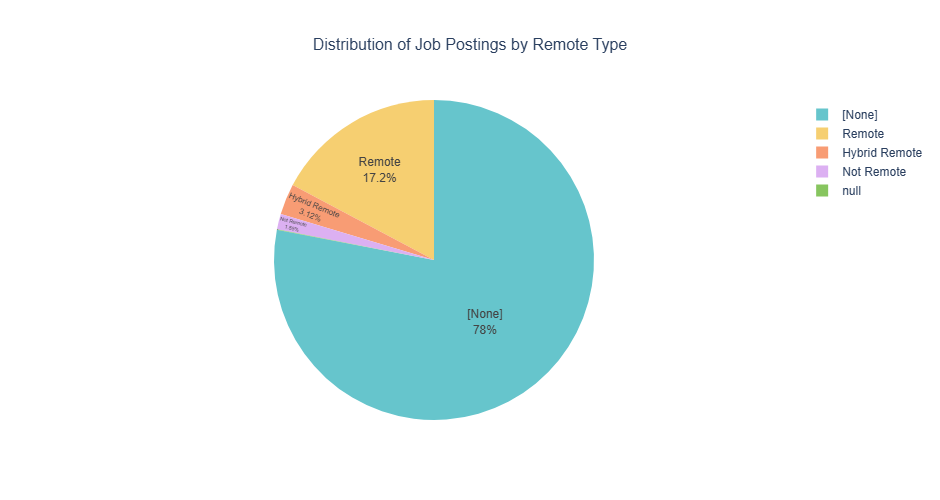

In [6]:
# Your code for 5th question here

# Remote Type Counts
remote_type_counts = df.groupBy("REMOTE_TYPE_NAME") \
    .agg(count("*").alias("Number of Postings")) \
    .select(col("REMOTE_TYPE_NAME").alias("Remote Type"), col("Number of Postings"))

fig = px.pie(
    remote_type_counts, 
    values='Number of Postings', 
    names='Remote Type',
    title='Distribution of Job Postings by Remote Type',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    template='plotly_white'
)

fig.update_layout(
    font=dict(family="Arial, sans-serif", size=12),
    title_font_size=16,
    title_x=0.5,
    height=500
)

fig.update_traces(textposition='inside', textinfo='percent+label')
pio.write_html(fig, file='remote_type_distribution.html')
fig.show()

The pie chart shows that a substantial majority of job postings (78.1%) are categorized as None, which likely indicates there are not remote jobs, while only 17.2% of postings are explicitly labeled as "Remote" and a small percentage (3.7%) are classified as "Hybrid Remote". This distribution suggests traditional work arrangements still dominating the job posting landscape.

# Skill Demand Analysis by Industry (Stacked Bar Chart)
- Identify which skills are most in demand in various industries.
- **Aggregate Data**
  - Extract **skills** from job postings.
  - Count occurrences of skills grouped by **NAICS industry codes**.
- **Visualize results**
  - Create a **stacked bar chart** where:
    - **X-axis** = `Industry`
    - **Y-axis** = `Skill Count`
    - **Color** = `Skill`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [7]:


df_with_skills = df.withColumn("SKILLS_NAME", 
    when(col("SKILLS_NAME").isNull(), lit(""))
    .otherwise(col("SKILLS_NAME"))
)

# Explode skills and filter out empty skills
skills_by_industry = df_with_skills.select(
    "NAICS2_NAME", 
    explode(split(col("SKILLS_NAME"), ",")).alias("SKILLS_NAME")
)

# Top Skills
top_skills = skills_by_industry.filter(col("SKILLS_NAME") != "") \
    .groupBy("SKILLS_NAME") \
    .agg(count("*").alias("skill_count")) \
    .orderBy(col("skill_count").desc()) \
    .limit(5)

top_skills_list = [row.SKILLS_NAME for row in top_skills.collect()]

skills_summary = skills_by_industry.filter(col("SKILLS_NAME").isin(top_skills_list)) \
    .groupBy("NAICS2_NAME") \
    .pivot("SKILLS_NAME", top_skills_list) \
    .agg(count("*")) \
    .na.fill(0) 

skills_summary_pd = skills_summary.toPandas()

skills_summary_melted = skills_summary_pd.melt(
    id_vars=['NAICS2_NAME'], 
    var_name='Skills', 
    value_name='Number of Job Postings'
)

fig = px.bar(
    skills_summary_melted, 
    x='NAICS2_NAME', 
    y='Number of Job Postings',
    color='Skills',
    title='Top Skills Demand Across Industries',
    labels={'NAICS2_NAME': 'Industry', 'Number of Job Postings': 'Number of Job Postings'},
    color_discrete_sequence=px.colors.qualitative.Pastel,
    template='plotly_white'
)

fig.update_layout(
    font=dict(family="Arial, sans-serif", size=12),
    title_font_size=16,
    title_x=0.5,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600,
    xaxis_tickangle=-45,
    legend_title_text='Skills'
)

pio.write_html(fig, file='skills_by_industry.html')
fig.show()

The graph reveals that Professional, Scientific, and Technical Services have the highest number of job postings, with a particularly strong demand for skills like Communication, Data Analysis, and Management. Across different industries, there's a consistent need for core skills such as Communication and Management, though the relative importance and volume of skills vary significantly between sectors like Public Administration, Real Estate, and Manufacturing.


# Salary Analysis by ONET Occupation Type (Bubble Chart)
- Analyze how salaries differ across ONET occupation types.
- **Aggregate Data**
  - Compute **median salary** for each occupation in the **ONET taxonomy**.
- **Visualize results**
  - Create a **bubble chart** where:
    - **X-axis** = `ONET_NAME`
    - **Y-axis** = `Median Salary`
    - **Size** = Number of job postings
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

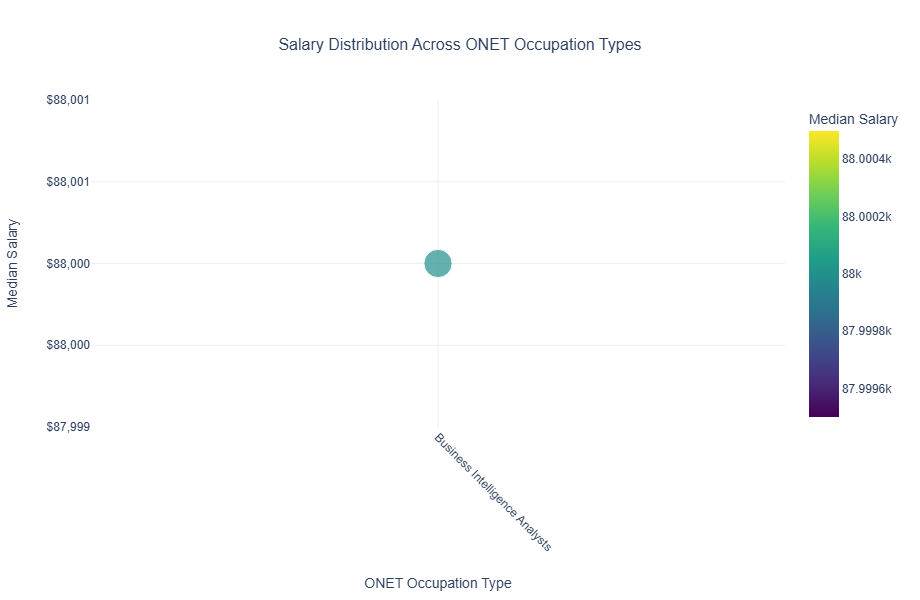

In [8]:
# Your code for 7th question here
# ONET Salary Summary
onet_salary_summary = df_filtered.groupBy("ONET_NAME") \
    .agg(
        F.percentile_approx("SALARY_FROM", 0.5).alias("Median_Salary"),
        count("*").alias("Job_Postings")
    )
fig = px.scatter(
    onet_salary_summary, 
    x='ONET_NAME', 
    y='Median_Salary',
    size='Job_Postings',
    color='Median_Salary',
    title='Salary Distribution Across ONET Occupation Types',
    labels={
        'ONET_NAME': 'ONET Occupation Type', 
        'Median_Salary': 'Median Salary',
        'Job_Postings': 'Number of Job Postings'
    },
    color_continuous_scale='Viridis',
    template='plotly_white',
    hover_name='ONET_NAME',
    hover_data=['Job_Postings']
)

fig.update_layout(
    font=dict(family="Arial, sans-serif", size=12),
    title_font_size=16,
    title_x=0.5,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600,
    width=1000
)

fig.update_xaxes(
    tickangle=45,
    title_standoff=25
)

fig.update_yaxes(
    title_standoff=25,
    tickformat='$,.0f'
)

pio.write_html(fig, file='onet_salary_bubble_chart.html')
fig.show()

The plot indicateds that the dataset has only one onet_name - Business Intelligence Analysts.

# Career Pathway Trends (Sankey Diagram)
- Visualize job transitions between different occupation levels.
- **Aggregate Data**
  - Identify career transitions between **SOC job classifications**.
- **Visualize results**
  - Create a **Sankey diagram** where:
    - **Source** = `SOC_2021_2_NAME`
    - **Target** = `SOC_2021_3_NAME`
    - **Value** = Number of transitions
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [9]:
# Your code for 8th question here
# Count transitions
transitions = df.groupBy(['SOC_2021_2_NAME', 'SOC_2021_3_NAME']) \
    .agg(count('*').alias('Value')) \
    .toPandas()

# Get unique labels
source_labels = transitions['SOC_2021_2_NAME'].unique()
target_labels = transitions['SOC_2021_3_NAME'].unique()

source_labels = source_labels[source_labels != None]
target_labels = target_labels[target_labels != None]

all_labels = np.unique(np.concatenate([source_labels, target_labels]))

# Create label to index mapping
label_to_index = {label: index for index, label in enumerate(all_labels)}

# Add source and target indices
transitions['source_index'] = transitions['SOC_2021_2_NAME'].map(label_to_index)
transitions['target_index'] = transitions['SOC_2021_3_NAME'].map(label_to_index)

# Create Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = all_labels,
      color = "blue"
    ),
    link = dict(
      source = transitions['source_index'],
      target = transitions['target_index'],
      value = transitions['Value']
  ))])

# Update layout
fig.update_layout(
    title_text="Career Pathway Transitions between SOC Job Classifications", 
    title_font_size=16,
    title_x=0.5,
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    height=600,
    width=1000,
    template='plotly_white'
)

# Save and show the figure
pio.write_html(fig, file='career_pathway_sankey.html')
fig.show()

It indicates that all Computer and Mathematical Occupations in 2021_2 changed to Mathematical Science Occupations. Perhaps the data were incorrectly entered with the same values, or a name change occurred.